<h3>Data Creation</h3>

For our model, there are certain indicators that we would like to create. These indicators can be created either with backtrader or put directly into the dataset.
Although for the Quallmaggie model we may want to create the indicators on an ad-hoc basis (with backtrader or quallmaggie), for many advanced machine learning models we will want to have the indicators in the dataset so that we can train on them.


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from ta.momentum import RSIIndicator as rsi
from ta.momentum import AwesomeOscillatorIndicator
from ta.trend import sma_indicator as sma
from ta.trend import EMAIndicator as ema
from ta.volume import VolumeWeightedAveragePrice as vwap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import seaborn as sns
sns.set()
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm

ModuleNotFoundError: No module named 'pandas'

In [2]:
#create and pull subset of stock data to work with
stocks_we_want = ["GOOGL", "AAPL", "TSLA", "MSFT"]
data = yf.download(tickers = stocks_we_want,
                  period = 'max',
                  interval = '1d',
                  group_by='ticker')


[*********************100%***********************]  4 of 4 completed


In [4]:
tesla_data = pd.read_csv("TSLA.csv", index_col=0)

In [7]:
tesla_data = data["TSLA"]

In [5]:
tesla_data.dropna(inplace=True)
tesla_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-05-26,44.099998,45.051998,43.810001,45.023998,45.023998,20362000
2016-05-27,44.998001,45.186001,44.150002,44.608002,44.608002,18251500
2016-05-31,44.608002,44.950001,44.299999,44.646000,44.646000,13945000
2016-06-01,44.296001,44.480000,43.377998,43.911999,43.911999,14913500
2016-06-02,43.917999,43.981998,43.422001,43.792000,43.792000,10164000


In [6]:
tesla_data.index

Index(['2016-05-26', '2016-05-27', '2016-05-31', '2016-06-01', '2016-06-02',
       '2016-06-03', '2016-06-06', '2016-06-07', '2016-06-08', '2016-06-09',
       ...
       '2021-05-12', '2021-05-13', '2021-05-14', '2021-05-17', '2021-05-18',
       '2021-05-19', '2021-05-20', '2021-05-21', '2021-05-24', '2021-05-25'],
      dtype='object', name='Date', length=1258)

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(tesla_data["Close"], model="Additive")
results.plot();

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

<h3>Time Series Data Exploration</h3>

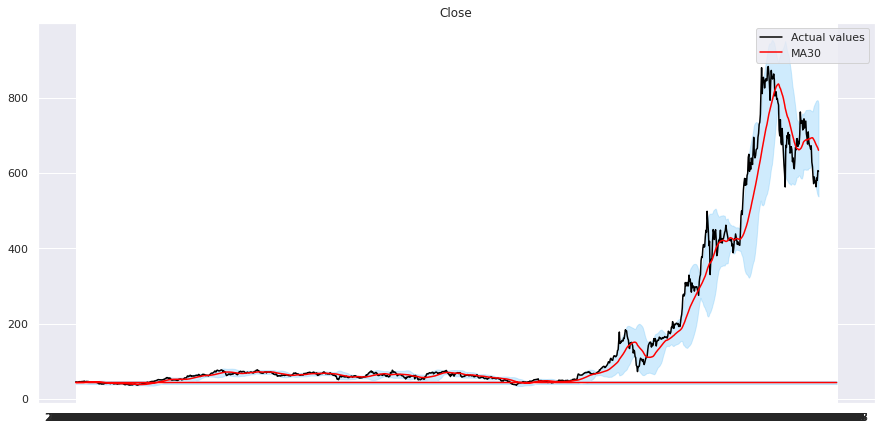

In [8]:
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30,
            figsize=(15,7)):    
   rolling_mean = ts.rolling(window=window).mean()    
   rolling_std = ts.rolling(window=window).std()
   plt.figure(figsize=figsize)    
   plt.title(ts.name)    
   plt.plot(ts[window:], label='Actual values', color="black")    
   if plot_ma:        
      plt.plot(rolling_mean, 'g', label='MA'+str(window),
               color="red")    
   if plot_intervals:
      lower_bound = rolling_mean - (1.96 * rolling_std)
      upper_bound = rolling_mean + (1.96 * rolling_std)
   plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                    color='lightskyblue', alpha=0.4)
   plt.legend(loc='best')
   plt.grid(True)
   plt.show()
plot_ts(tesla_data.Close, window=30)

In [9]:
def find_outliers(ts, perc=0.01, figsize=(15,5)):
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["index"] = range(len(ts))
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                              x: 1 if x==-1 else 0)
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title="Outliers detection: found"
           +str(sum(dtf_outliers["outlier"]==1)))
    ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
            color="black")
    ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
               y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
               color='red')
    ax.grid(True)
    plt.show()
    return dtf_outliers

'''
Interpolate outliers in a ts.
'''
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
    ts_clean = ts.copy()
    ts_clean.loc[outliers_idx] = np.nan
    ts_clean = ts_clean.interpolate(method="linear")
    ax = ts.plot(figsize=figsize, color="red", alpha=0.5,
         title="Remove outliers", label="original", legend=True)
    ts_clean.plot(ax=ax, grid=True, color="black",
                  label="interpolated", legend=True)
    plt.show()
    return ts_clean

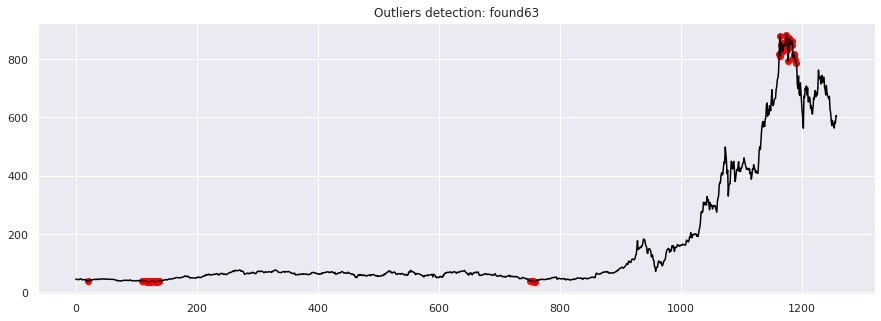

In [10]:
dtf_outliers = find_outliers(tesla_data.Close, perc=0.05)

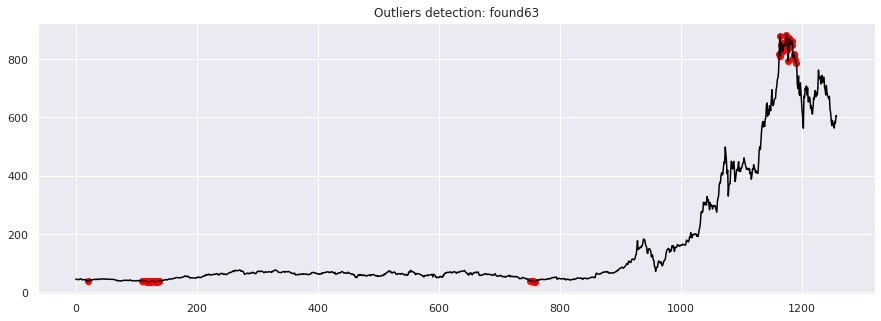

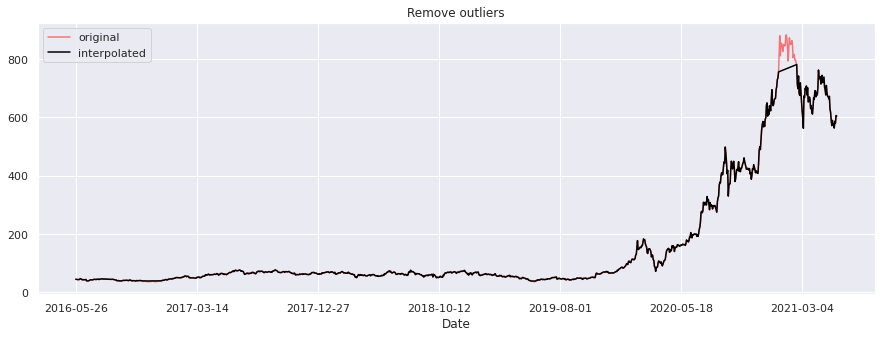

In [11]:
'''
Interpolate outliers in a ts.
'''
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
    ts_clean = ts.copy()
    ts_clean.loc[outliers_idx] = np.nan
    ts_clean = ts_clean.interpolate(method="linear")
    ax = ts.plot(figsize=figsize, color="red", alpha=0.5,
         title="Remove outliers", label="original", legend=True)
    ts_clean.plot(ax=ax, grid=True, color="black",
                  label="interpolated", legend=True)
    plt.show()
    return ts_clean
dtf_outliers = find_outliers(tesla_data.Close, perc=0.05)
## outliers index position
outliers_index_pos = dtf_outliers[dtf_outliers["outlier"]==1].index## exclude outliers
ts_clean = remove_outliers(tesla_data.Close, outliers_idx=outliers_index_pos)

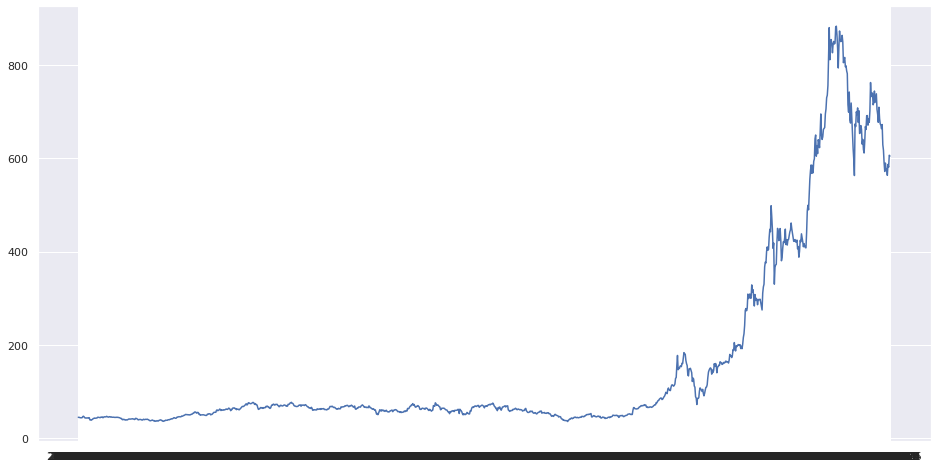

In [13]:
#looking at the closing price of the tesls stoc
plt.figure(figsize=(16,8))
plt.plot(tesla_data.Close, label="Closing Price over time")

<h3>Feature Engineering</h3>
<h4>Feature Engineering Momentum Indicators</h4>
This is the list of indicators that we will be adding to our dataset
- note that when a calculation gives us a value of NaN we will be filling it with 0 (but only for technical indicators)
- Note that all stocks will vary when the rows stop all being NaN because stocks have different IPOs (obviously)m so before training for each stock you will have to find the first data in which the Open, high, Low, Close, Adj Close and Volume are not all 0s

Indicators:
<ol>
    <li>RSI</li>
    <li>Simple Moving Average(10, 20, 50, 100, 200)</li>
    <li>Exponential Moving Average(10, 20, 50, 100, 200) </li>
    <li>VWAP</li>
    <li>RSI</li>
</ol>

In [4]:
data.head()

TSLA                                 GOOGL                 \
           Open High Low Close Adj Close Volume  Open High Low Close   
Date                                                                   
1980-12-12  NaN  NaN NaN   NaN       NaN    NaN   NaN  NaN NaN   NaN   
1980-12-15  NaN  NaN NaN   NaN       NaN    NaN   NaN  NaN NaN   NaN   
1980-12-16  NaN  NaN NaN   NaN       NaN    NaN   NaN  NaN NaN   NaN   
1980-12-17  NaN  NaN NaN   NaN       NaN    NaN   NaN  NaN NaN   NaN   
1980-12-18  NaN  NaN NaN   NaN       NaN    NaN   NaN  NaN NaN   NaN   

                                 AAPL                                          \
           Adj Close Volume      Open      High       Low     Close Adj Close   
Date                                                                            
1980-12-12       NaN    NaN  0.128348  0.128906  0.128348  0.128348  0.100751   
1980-12-15       NaN    NaN  0.122210  0.122210  0.121652  0.121652  0.095495   
1980-12-16       NaN    NaN  0.113281  0.113281  0.112723  0.112723  0.088485   
1980-12-17       NaN    NaN  0.115513  0.116071  0.115513  0.115513  0.090676   
1980-12-18       NaN    NaN  0.118862  0.119420  0.118862  0.118862  0.093304   

                      MSFT                                  
               Volume Open High Low Close Adj Close Volume  
Date                                                        
1980-12-12  469033600  NaN  NaN NaN   NaN       NaN    NaN  
1980-12-15  175884800  NaN  NaN NaN   NaN       NaN    NaN  
1980-12-16  105728000  NaN  NaN NaN   NaN       NaN    NaN  
1980-12-17   86441600  NaN  NaN NaN   NaN       NaN    NaN  
1980-12-18   73449600  NaN  NaN NaN   NaN       NaN    NaN

In [5]:
#loop through each stock dataframe in our data, and add the neccesary indicator
#get a list of all the stocks in dataset using some code borrowed from stackoverflow
stock_symbols = {idx: gp.xs(idx, level=0, axis=1) for idx, gp in data.groupby(level=0, axis=1)}.keys() #just to get column names, no idea what it foes

#from here its our code
for stock in stock_symbols:
    data[stock,"Sma_10"] = sma(data[stock].Close, window=10, fillna=False)
    data[stock,"Sma_20"] = sma(data[stock].Close, window=20, fillna=False)
    data[stock,"Sma_50"] = sma(data[stock].Close, window=50, fillna=False)
    data[stock,"Sma_100"] = sma(data[stock].Close, window=100, fillna=False)
    data[stock,"Sma_200"] = sma(data[stock].Close, window=200, fillna=False)
    data[stock, "Ema_10"] = ema(data[stock].Close, window=10, fillna=False).ema_indicator()
    data[stock, "Ema_20"] = ema(data[stock].Close, window=20, fillna=False).ema_indicator()
    data[stock, "Ema_50"] = ema(data[stock].Close, window=50, fillna=False).ema_indicator()
    data[stock, "Ema_100"] = ema(data[stock].Close, window=100, fillna=False).ema_indicator()
    data[stock, "Ema_200"] = ema(data[stock].Close, window=200, fillna=False).ema_indicator()
    data[stock, "RSI"] = rsi(data[stock].Close, window=6, fillna=False).rsi()
    data[stock, "VWAP"] = vwap(high=data[stock].High, low=data[stock].Low,
                               close=data[stock].Close, volume=data[stock].Volume, window=14, fillna=False).volume_weighted_average_price()

<h4>Feature Engineering for Stock Screener</h4>

In Quallmaggies strategy, he employs a stock screener that checks for certain stocks that fit given characteristics. In order to get the MVP of this model out, we will only use 1 out of the 3 stock screeners.

For the MVP of the model, the model will simply buy the top 3 stocks that are at the top of the stock screener. For future iterations, a regression model will be built.

Screener things to be added: 1 month gainer, 3 month gainer, 6 month gainer

In the subsequent cell, our goal is to create useful indicators that may help with detecting a potential breakout

In [6]:
#to be used for screening stocks, not for trading
def get_ADR_20(highs, lows):
    #need to start at least 22 days form the first non-null day
    result = 100 *((highs / lows + highs.shift(1) / lows.shift(1) + highs.shift(2) / lows.shift(2) +\
                    highs.shift(3)/lows.shift(3) + highs.shift(4)/lows.shift(4) + highs.shift(5)/lows.shift(5) +\
                    highs.shift(6)/lows.shift(6) +highs.shift(7)/lows.shift(7) + highs.shift(8)/lows.shift(8) +\
                    highs.shift(9)/lows.shift(9) + highs.shift(10)/lows.shift(10) + highs.shift(11)/lows.shift(11) +\
                    highs.shift(12)/lows.shift(12) + highs.shift(13)/lows.shift(13) + highs.shift(14)/lows.shift(14) +\
                    highs.shift(15)/lows.shift(15) + highs.shift(16)/lows.shift(16) + highs.shift(17)/lows.shift(17) + \
                    highs.shift(18)/lows.shift(18) + highs.shift(19)/lows.shift(19))/20 - 1)
    return result
#to be used for screening stocks, not for trading
def get_price_growth(low, close, time_period = 1):
    low = low.copy(deep=True) #getting rid of any referencing if any reference
    low = low.reset_index()
    min_low_22 = pd.DataFrame([low, low.shift(1), low.shift(2), low.shift(3),
                              low, low.shift(4), low.shift(5), low.shift(6),
                              low, low.shift(7), low.shift(8), low.shift(9),
                              low, low.shift(10), low.shift(11), low.shift(12),
                              low, low.shift(13), low.shift(14), low.shift(15),
                              low, low.shift(16), low.shift(17), low.shift(18),
                              low, low.shift(19), low.shift(20), low.shift(21),
                              low.shift(22)])
    
    return close / min_low_22

#indicators to be used for training
def price_ma_difference_indicator(data, indicator_list):
    """
    Given a list of moving average indicators (whether simple of exponential), return the difference between
    price and moving average. 
    The indicators created by this function indicate when the price touches the moving average, or when
    price dips below moving average or is far above it. Should be good for anticipating momentum bursts
    
    Parameters
    ----------
    data: pandas DataFrame
        DataFrame with first column level being stock data, and next level being data for preceding level ticker
        
    indicator_list: [str]
        list of strings of
        
    Returns
    ----------
    None
    
    """
   
    for indicator in indicator_list:
        #for each indicator in list (which should only be moving averages)
        #for each moving average, calculate the difference between that and Close
        
        #get a list of all the stocks that are in the dataset
        difference_name = indicator + '_diff_with_price'
        tickers = list(data.columns.levels[0])
        
        for ticker in tickers:
            data[ticker, difference_name] = data[ticker, 'Close'] - data[ticker, indicator]
    
        
        
        

mas_find_diff_with_price = ["Sma_10", "Sma_20", "Sma_50", "Ema_10", "Ema_20", "Ema_50"]
price_ma_difference_indicator(data,mas_find_diff_with_price)
        


In [7]:
#we will design this stock screener to be used whenever
#for training purposes (so we calculate once) let us add these relevant columns to the dataset
for stock in stock_symbols:
    data[stock, "volume_1day"] = data[stock].Close * data[stock].Volume / 100 #filter for greater than 1000000
    data[stock, "volume_1day_condition"] = data[stock, "volume_1day"] > 1000000
    data[stock, "ADR_20_Days"] = get_ADR_20(data[stock].High, data[stock].Low) #filter for greater than 5
    data[stock, "ADR_20_Days_condition"] = data[stock, "ADR_20_Days"] > 5
    #data[stock, "price_growth_1m"] = get_price_growth(data[stock].Low,data[stock].Close, 1) 
    #data[stock, "Price_Growth_3_Month"] = data[stock].Close
    #data[stock, "Price_Growth_6_month"] = data[stock]

Turn this problem into a supervised learning problem.
What we will try here is try fitting a linear regression model, trying out 5 different models with different targets (predicting diffrent number of days into the future). Then we will also try the average prediction of these models

In [8]:
def series_to_supervised(data, ticker, target_name, dropna=True):
    """
    Given a time series dataset and a target, frame as supervised learning problem.
    
    """
    data[ticker, "Y_1"] = data[ticker, target_name].shift(periods=1) #one day in advance
    data[ticker, "Y_2"] = data[ticker, target_name].shift(periods=2)
    data[ticker, "Y_3"] = data[ticker, target_name].shift(periods=3)
    data[ticker, "Y_4"] = data[ticker, target_name].shift(periods=4)
    data[ticker, "Y_5"] = data[ticker, target_name].shift(periods=5)
    #all modifications happen in place
    
for stock in stock_symbols:
    series_to_supervised(data, stock, "Close")




In [9]:
#fit model for only Google to test out model
data_googl = data["GOOGL"].copy(deep=True)
data_googl.dropna(inplace=True)
data_googl.head()

,Open,High,Low,Close,Adj Close,Volume,Sma_10,Sma_20,Sma_50,Sma_100,Sma_200,Ema_10,Ema_20,Ema_50,Ema_100,Ema_200,RSI,VWAP,Sma_10_diff_with_price,Sma_20_diff_with_price,Sma_50_diff_with_price,Ema_10_diff_with_price,Ema_20_diff_with_price,Ema_50_diff_with_price,volume_1day,volume_1day_condition,ADR_20_Days,ADR_20_Days_condition,Y_1,Y_2,Y_3,Y_4,Y_5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-06-03,143.538544,144.794800,138.843842,140.270264,140.270264,37527035.0,133.758760,124.777528,109.857658,102.367668,89.816216,134.510729,127.124883,114.776552,104.895239,92.353073,73.867719,132.267646,6.511504,15.492736,30.412606,5.759535,13.145380,25.493712,5.263927e+07,True,2.497983,False,144.094101,144.144150,138.773773,133.133133,129.729736
2005-06-06,141.336334,147.022018,141.056061,145.615616,145.615616,45006748.0,136.227729,126.352102,110.975676,102.855155,90.293193,136.529799,128.885905,115.985927,105.701583,92.883048,81.125366,133.767151,9.387887,19.263514,34.639940,9.085817,16.729710,29.629689,6.553685e+07,True,2.648081,False,140.270264,144.094101,144.144150,138.773773,133.133133
2005-06-07,148.698700,149.944946,145.295288,146.706711,146.706711,48597354.0,138.113115,128.031282,112.093794,103.344345,90.755681,138.380147,130.583125,117.190663,106.513566,93.418607,82.327580,135.524041,8.593596,18.675429,34.612917,8.326564,16.123586,29.516047,7.129558e+07,True,2.739996,False,145.615616,140.270264,144.094101,144.144150,138.773773
2005-06-08,146.571579,146.741745,139.139145,139.919922,139.919922,51350398.0,139.292294,129.326577,113.094695,103.765916,91.181506,138.660106,131.472344,118.082007,107.175078,93.881307,55.799046,136.849134,0.627628,10.593345,26.825227,1.259816,8.447578,21.837915,7.184944e+07,True,2.944668,False,146.706711,145.615616,140.270264,144.094101,144.144150
2005-06-09,142.502502,144.394394,140.420425,143.298294,143.298294,32849318.0,140.568570,130.703454,114.154355,104.198048,91.635560,139.503413,132.598625,119.070881,107.890389,94.373018,62.933681,137.763309,2.729724,12.594840,29.143940,3.794881,10.699669,24.227413,4.707251e+07,True,2.997327,False,139.919922,146.706711,145.615616,140.270264,144.094101


In [10]:
#use 0-1 encoding for volume_1day_condition	, ADR_20_Days_condition
data_googl["volume_1day_condition"] = pd.Series([1 if x == True else 0 for x in data_googl["volume_1day_condition"]]).values
data_googl["ADR_20_Days_condition"] = pd.Series([1 if x == True else 0 for x in data_googl["ADR_20_Days_condition"]]).values
data_googl.head()

,Open,High,Low,Close,Adj Close,Volume,Sma_10,Sma_20,Sma_50,Sma_100,Sma_200,Ema_10,Ema_20,Ema_50,Ema_100,Ema_200,RSI,VWAP,Sma_10_diff_with_price,Sma_20_diff_with_price,Sma_50_diff_with_price,Ema_10_diff_with_price,Ema_20_diff_with_price,Ema_50_diff_with_price,volume_1day,volume_1day_condition,ADR_20_Days,ADR_20_Days_condition,Y_1,Y_2,Y_3,Y_4,Y_5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-06-03,143.538544,144.794800,138.843842,140.270264,140.270264,37527035.0,133.758760,124.777528,109.857658,102.367668,89.816216,134.510729,127.124883,114.776552,104.895239,92.353073,73.867719,132.267646,6.511504,15.492736,30.412606,5.759535,13.145380,25.493712,5.263927e+07,1,2.497983,0,144.094101,144.144150,138.773773,133.133133,129.729736
2005-06-06,141.336334,147.022018,141.056061,145.615616,145.615616,45006748.0,136.227729,126.352102,110.975676,102.855155,90.293193,136.529799,128.885905,115.985927,105.701583,92.883048,81.125366,133.767151,9.387887,19.263514,34.639940,9.085817,16.729710,29.629689,6.553685e+07,1,2.648081,0,140.270264,144.094101,144.144150,138.773773,133.133133
2005-06-07,148.698700,149.944946,145.295288,146.706711,146.706711,48597354.0,138.113115,128.031282,112.093794,103.344345,90.755681,138.380147,130.583125,117.190663,106.513566,93.418607,82.327580,135.524041,8.593596,18.675429,34.612917,8.326564,16.123586,29.516047,7.129558e+07,1,2.739996,0,145.615616,140.270264,144.094101,144.144150,138.773773
2005-06-08,146.571579,146.741745,139.139145,139.919922,139.919922,51350398.0,139.292294,129.326577,113.094695,103.765916,91.181506,138.660106,131.472344,118.082007,107.175078,93.881307,55.799046,136.849134,0.627628,10.593345,26.825227,1.259816,8.447578,21.837915,7.184944e+07,1,2.944668,0,146.706711,145.615616,140.270264,144.094101,144.144150
2005-06-09,142.502502,144.394394,140.420425,143.298294,143.298294,32849318.0,140.568570,130.703454,114.154355,104.198048,91.635560,139.503413,132.598625,119.070881,107.890389,94.373018,62.933681,137.763309,2.729724,12.594840,29.143940,3.794881,10.699669,24.227413,4.707251e+07,1,2.997327,0,139.919922,146.706711,145.615616,140.270264,144.094101


<h4>Understanding Correlations</h4>

One big assumptions that we are making is that these momentum indicators are highly correlated with Income. If there is no correlation (or if the relationship is random) then our model will fail.

Let us plot these momentum indicators against income to see the correlation


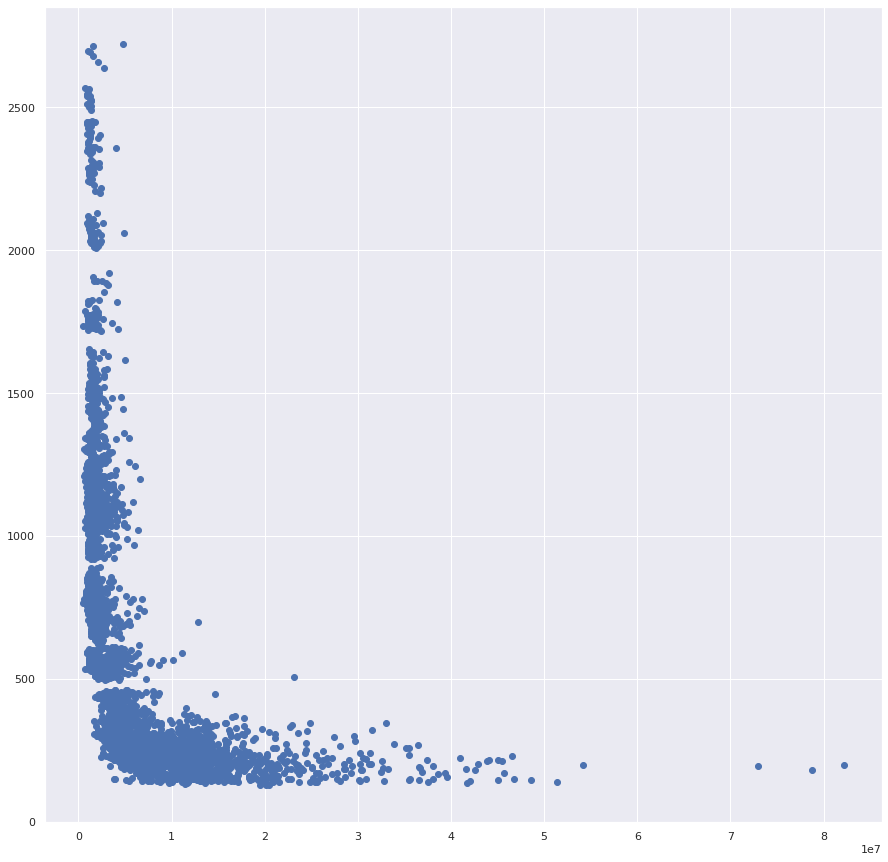

In [11]:
#plot all the moving averages against income, and see if there is a correlation between the two
#as income increases, how does volume change
plt.figure(figsize=(15,15))
plt.scatter(data_googl["Volume"], data_googl["Close"])  # let x be income, y be volume
plt.show()

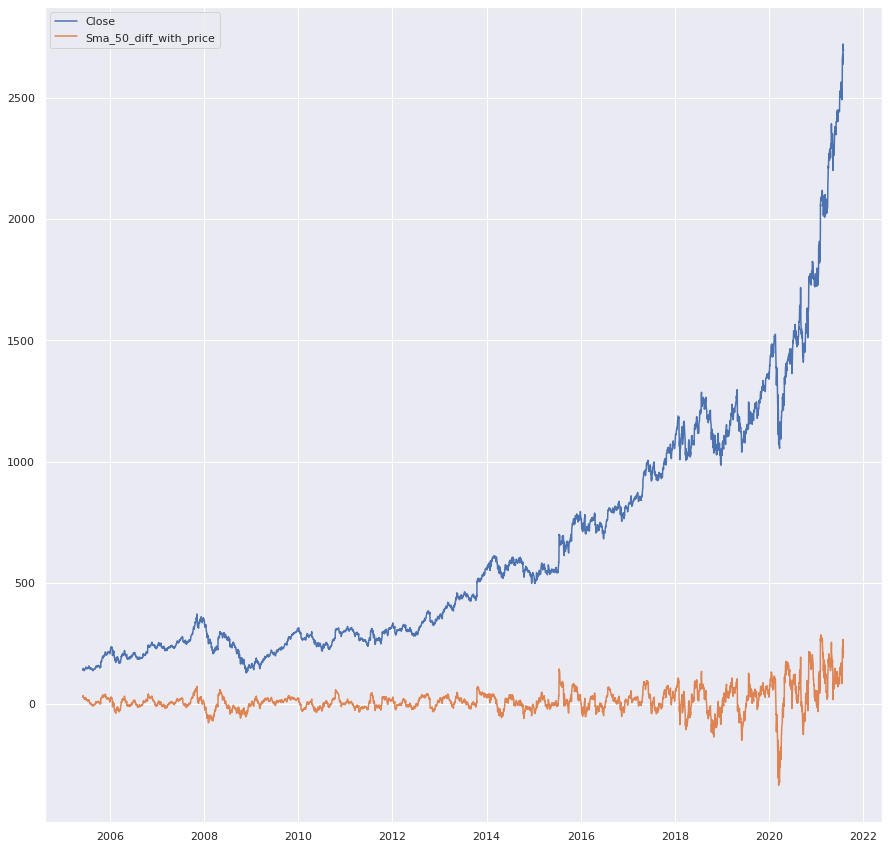

In [12]:
plt.figure(figsize=(15,15))
plt.plot(data_googl["Close"], label="Close")
plt.plot(data_googl["Sma_50_diff_with_price"], label="Sma_50_diff_with_price")
plt.legend(loc='best')
plt.show()

It might be good to even add an indicator that says whether the difference between the moving averages and the price is positive or negative.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


For this model we will be using linear regression (OLS). In order to be successful with this model we need to validate the Gauss Markov assumptions. Once the assumptions have been validated, we will fit a linear regression model on all the features that we have. The goal will be to buy when our model predicts that the next period's price will be higher than the closing price, and sell when the model predicts that the next period price will be lower than the closing price.

There are certain reasons why this model may not perform 100% accurately:
1. We are assuming that the features that we have created have a linear relationship with the closing price in future periods. That may not be the case, and using various charts we can try to infer what type of relationship there might be.
2. We are assuming that the feature we have created are not highly correlated with each other, which intuitively we know is not true as some feature are engineered from others.

Gauss Markov Assumptions will have to be validated before we can truly get accurate results

In future iterations we will have to validate each of our assumptions, and also use Regression Diagnostics to validate the relationship betwee


<h4>Train/Test Split</h4>

In future iterations we use Time Series Cross Validation. Also, we would have to use the m

In [13]:
#do 60, 40 split
split_index = int(data_googl.shape[0] * 0.80) #60/40 train test split
train_googl = data_googl.iloc[:split_index, :]
X_train_googl = train_googl.iloc[:,:28]
y1_train_googl = train_googl["Y_1"]
y2_train_googl = train_googl["Y_2"]
y3_train_googl = train_googl["Y_3"]
y4_train_googl = train_googl["Y_4"]
y5_train_googl = train_googl["Y_5"]
test_googl = data_googl.iloc[split_index:,:]
X_test_googl = test_googl.iloc[:,:28]
y1_test_googl = test_googl["Y_1"]
y2_test_googl = test_googl["Y_2"]
y3_test_googl = test_googl["Y_3"]
y4_test_googl = test_googl["Y_4"]
y5_test_googl = test_googl["Y_5"]

In [14]:
X_train_googl.head()

,Open,High,Low,Close,Adj Close,Volume,Sma_10,Sma_20,Sma_50,Sma_100,Sma_200,Ema_10,Ema_20,Ema_50,Ema_100,Ema_200,RSI,VWAP,Sma_10_diff_with_price,Sma_20_diff_with_price,Sma_50_diff_with_price,Ema_10_diff_with_price,Ema_20_diff_with_price,Ema_50_diff_with_price,volume_1day,volume_1day_condition,ADR_20_Days,ADR_20_Days_condition
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-06-03,143.538544,144.794800,138.843842,140.270264,140.270264,37527035.0,133.758760,124.777528,109.857658,102.367668,89.816216,134.510729,127.124883,114.776552,104.895239,92.353073,73.867719,132.267646,6.511504,15.492736,30.412606,5.759535,13.145380,25.493712,5.263927e+07,1,2.497983,0
2005-06-06,141.336334,147.022018,141.056061,145.615616,145.615616,45006748.0,136.227729,126.352102,110.975676,102.855155,90.293193,136.529799,128.885905,115.985927,105.701583,92.883048,81.125366,133.767151,9.387887,19.263514,34.639940,9.085817,16.729710,29.629689,6.553685e+07,1,2.648081,0
2005-06-07,148.698700,149.944946,145.295288,146.706711,146.706711,48597354.0,138.113115,128.031282,112.093794,103.344345,90.755681,138.380147,130.583125,117.190663,106.513566,93.418607,82.327580,135.524041,8.593596,18.675429,34.612917,8.326564,16.123586,29.516047,7.129558e+07,1,2.739996,0
2005-06-08,146.571579,146.741745,139.139145,139.919922,139.919922,51350398.0,139.292294,129.326577,113.094695,103.765916,91.181506,138.660106,131.472344,118.082007,107.175078,93.881307,55.799046,136.849134,0.627628,10.593345,26.825227,1.259816,8.447578,21.837915,7.184944e+07,1,2.944668,0
2005-06-09,142.502502,144.394394,140.420425,143.298294,143.298294,32849318.0,140.568570,130.703454,114.154355,104.198048,91.635560,139.503413,132.598625,119.070881,107.890389,94.373018,62.933681,137.763309,2.729724,12.594840,29.143940,3.794881,10.699669,24.227413,4.707251e+07,1,2.997327,0


In future iterations we will use grid search to tune the hyper parameters of OLS. 

In [15]:
ols1 = LinearRegression(n_jobs=4)
ols1.fit(X_train_googl, y1_train_googl)
ols2 = LinearRegression(n_jobs=4)
ols2.fit(X_train_googl, y2_train_googl)
ols3 = LinearRegression(n_jobs=4)
ols3.fit(X_train_googl, y3_train_googl)
ols4 = LinearRegression(n_jobs=4)
ols4.fit(X_train_googl, y4_train_googl)
ols5 = LinearRegression(n_jobs=4)
ols5.fit(X_train_googl, y5_train_googl)
#ols1.score(X_test_googl, y_test_googl)
#get predictions
prediction1 = ols1.predict(X_test_googl)
prediction2 = ols2.predict(X_test_googl)
prediction3 = ols3.predict(X_test_googl)
prediction4 = ols4.predict(X_test_googl)
prediction5 = ols5.predict(X_test_googl)

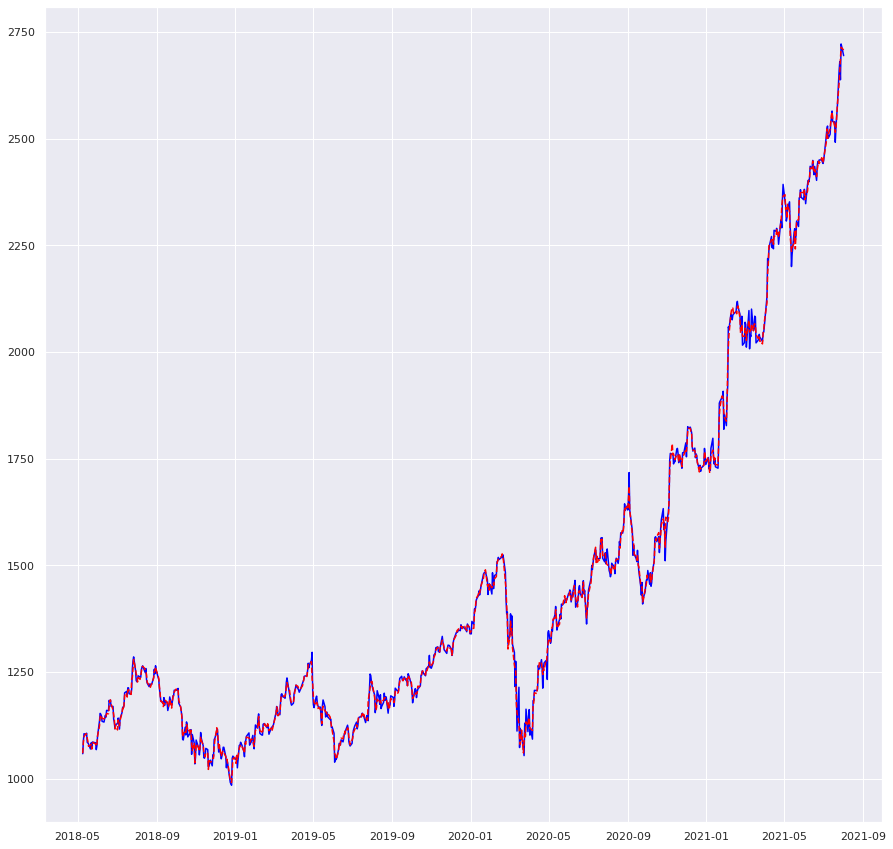

In [16]:
#plot figure
x = X_test_googl.reset_index()['Date']
y1 = y1_test_googl.values
y2 = prediction1
plt.figure(figsize=(15,15))
plt.plot(x, y1, label="Closing Price", color="blue")
plt.plot(x, y2, label="Predicted Price",color="red", linestyle="dashed")
plt.show()

In [17]:
#how accurate is the model in predicting the direction of the stock
# We will assess the accuracy of the model by shifting shifting the prediction of the model (which is in the next time step) by 1. Then, we will find the difference between the closing price and the predicted price
# If the result is positive, we add to a positive count. If result is negative, we add to a negative count. Keeping a total count as well

accuracy_frame = pd.DataFrame(columns=["Close", "Prediction"])
accuracy_frame["Close"] = y1
accuracy_frame["Prediction"] = pd.Series(y2).shift(-1).values
accuracy_frame["Difference"] = accuracy_frame["Close"] - accuracy_frame["Prediction"]
positives, negatives = 0, 0
for diff in accuracy_frame["Difference"]:
    if diff < 0:
        negatives += 1
    else:
        positives +=1 

In [18]:
positives / (negatives+ positives)

0.4668304668304668

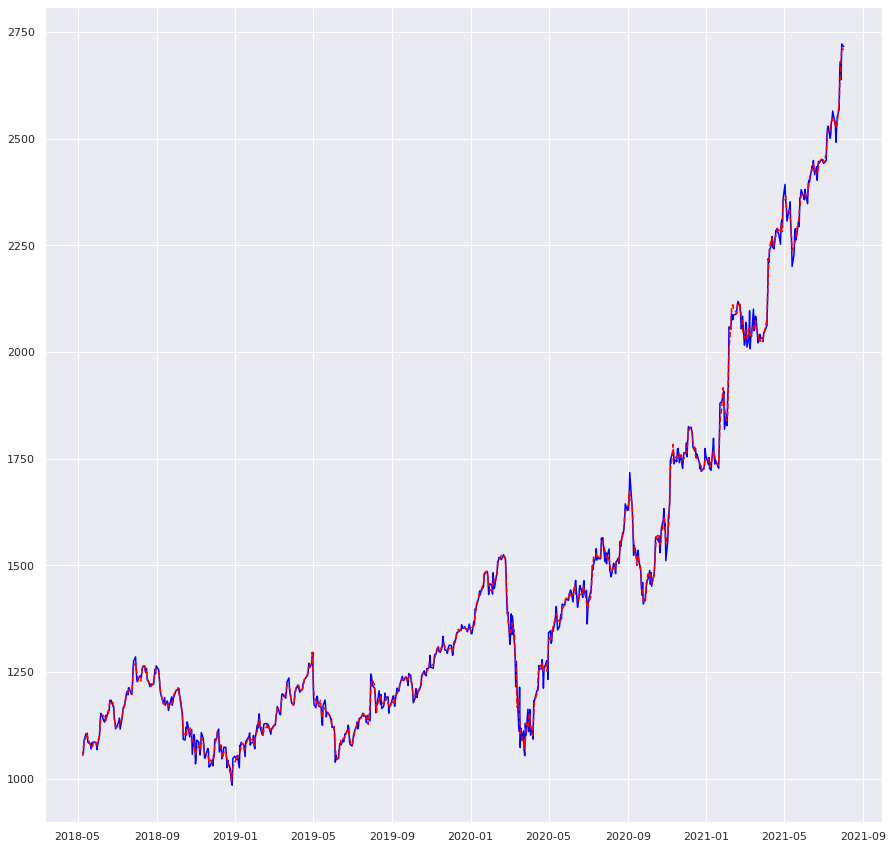

In [19]:
#plot figure
x = X_test_googl.reset_index()['Date']
y1 = y2_test_googl.values
y2 = prediction2
plt.figure(figsize=(15,15))
plt.plot(x, y1, label="Closing Price", color="blue")
plt.plot(x, y2, label="Predicted Price",color="red", linestyle="dashed")
plt.show()

In [20]:
accuracy_frame = pd.DataFrame(columns=["Close", "Prediction"])
accuracy_frame["Close"] = y1
accuracy_frame["Prediction"] = pd.Series(y2).shift(-1).values
accuracy_frame["Difference"] = accuracy_frame["Close"] - accuracy_frame["Prediction"]
positives, negatives = 0, 0
for diff in accuracy_frame["Difference"]:
    if diff < 0:
        negatives += 1
    else:
        positives +=1 

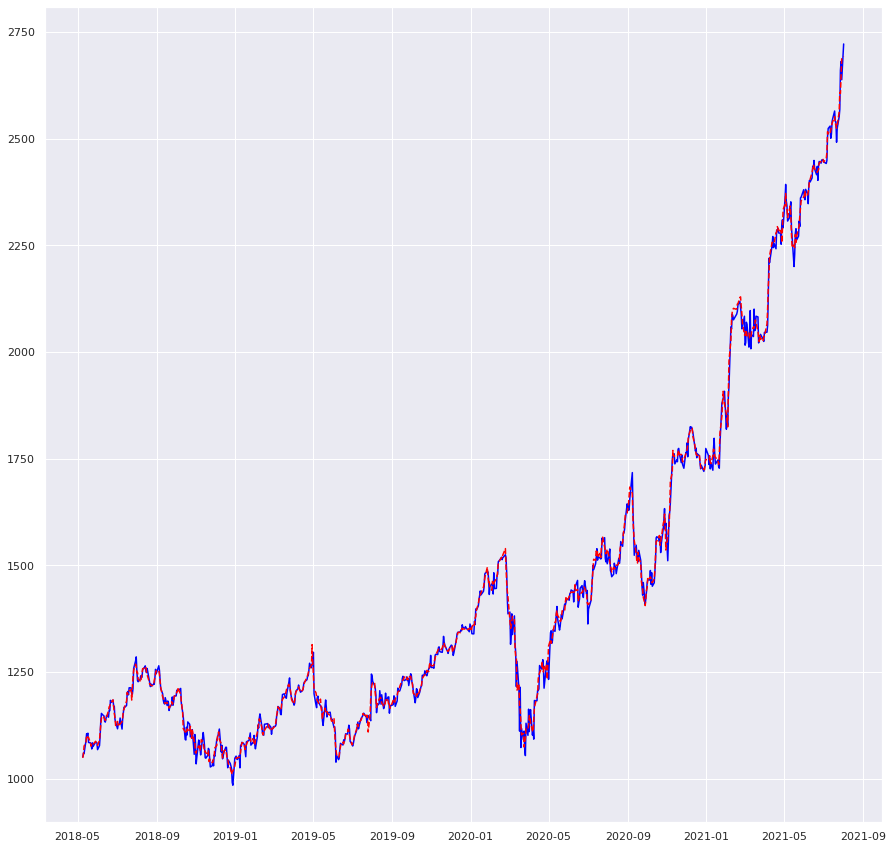

In [21]:
#plot figure
x = X_test_googl.reset_index()['Date']
y1 = y3_test_googl.values
y2 = prediction3
plt.figure(figsize=(15,15))
plt.plot(x, y1, label="Closing Price", color="blue")
plt.plot(x, y2, label="Predicted Price",color="red", linestyle="dashed")
plt.show()

In [22]:
accuracy_frame = pd.DataFrame(columns=["Close", "Prediction"])
accuracy_frame["Close"] = y1
accuracy_frame["Prediction"] = pd.Series(y2).shift(-1).values
accuracy_frame["Difference"] = accuracy_frame["Close"] - accuracy_frame["Prediction"]
positives, negatives = 0, 0
for diff in accuracy_frame["Difference"]:
    if diff < 0:
        negatives += 1
    else:
        positives +=1 

In [23]:
#plot figure
x = X_test_googl.reset_index()['Date']
y1 = y4_test_googl.values
y2 = prediction4
plt.figure(figsize=(15,15))
plt.show()

<Figure size 1080x1080 with 0 Axes>

In [24]:
accuracy_frame = pd.DataFrame(columns=["Close", "Prediction"])
accuracy_frame["Close"] = y1
accuracy_frame["Prediction"] = pd.Series(y2).shift(-1).values
accuracy_frame["Difference"] = accuracy_frame["Close"] - accuracy_frame["Prediction"]
positives, negatives = 0, 0
for diff in accuracy_frame["Difference"]:
    if diff < 0:
        negatives += 1
    else:
        positives +=1 

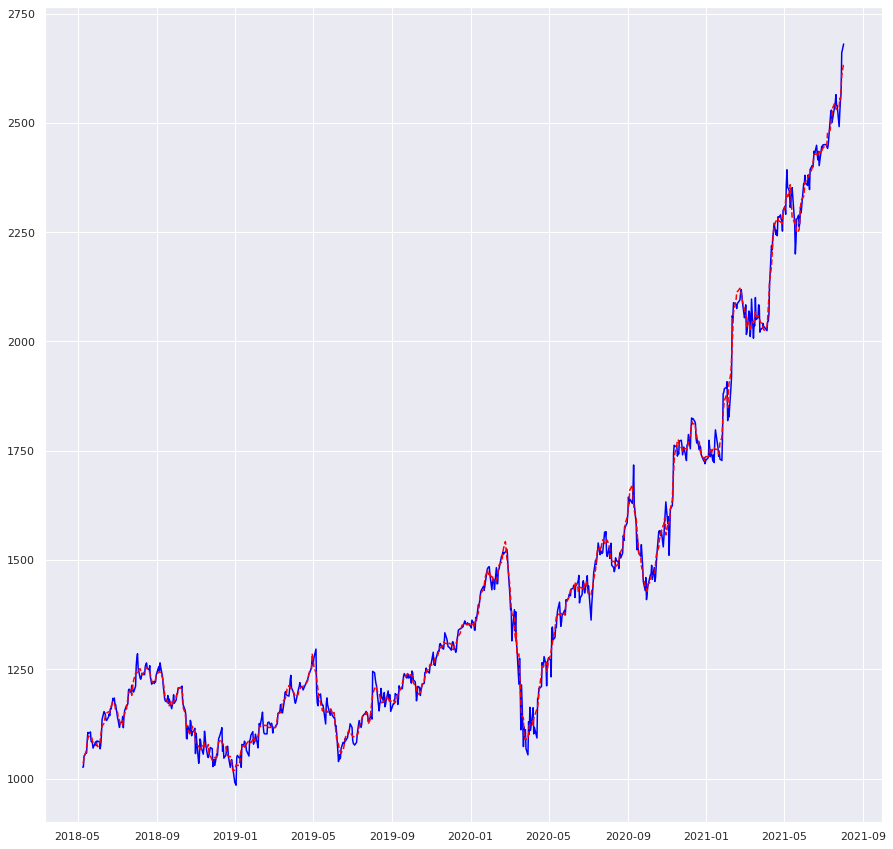

In [25]:
#plot figure
x = X_test_googl.reset_index()['Date']
y1 = y5_test_googl.values
y2 = prediction5
plt.figure(figsize=(15,15))
plt.plot(x, y1, label="Closing Price", color="blue")
plt.plot(x, y2, label="Predicted Price",color="red", linestyle="dashed")
plt.show()

In [26]:
accuracy_frame = pd.DataFrame(columns=["Close", "Prediction"])
accuracy_frame["Close"] = y1
accuracy_frame["Prediction"] = pd.Series(y2).shift(-1).values
accuracy_frame["Difference"] = accuracy_frame["Close"] - accuracy_frame["Prediction"]
positives, negatives = 0, 0
for diff in accuracy_frame["Difference"]:
    if diff < 0:
        negatives += 1
    else:
        positives +=1 

In [28]:
positives / (positives + negatives)

0.4484029484029484

Let us train a logistic regression model that predicts whether the stock price will go up or down

<h3>Gauss Markov Assumptions Test</h3>

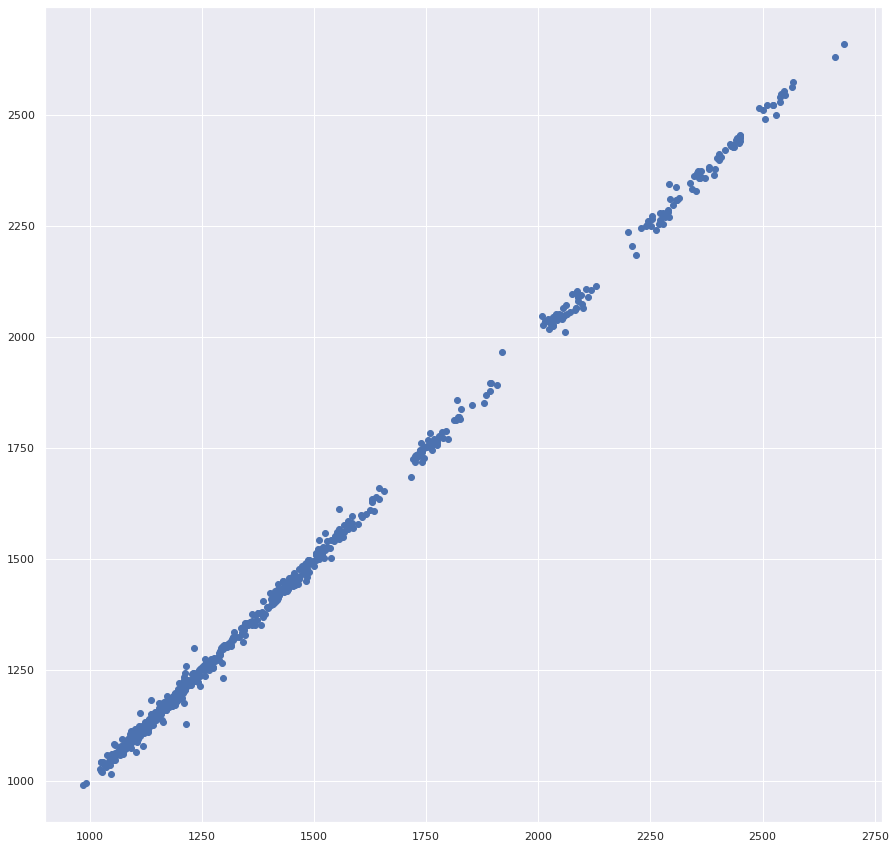

In [48]:
#Assumption 1: Linearity of Model
#observing plots of observed vs predicted or resuduals cs predicted
plt.figure(figsize=(15,15))
plt.scatter(y1, y2)
plt.show()

<AxesSubplot:>

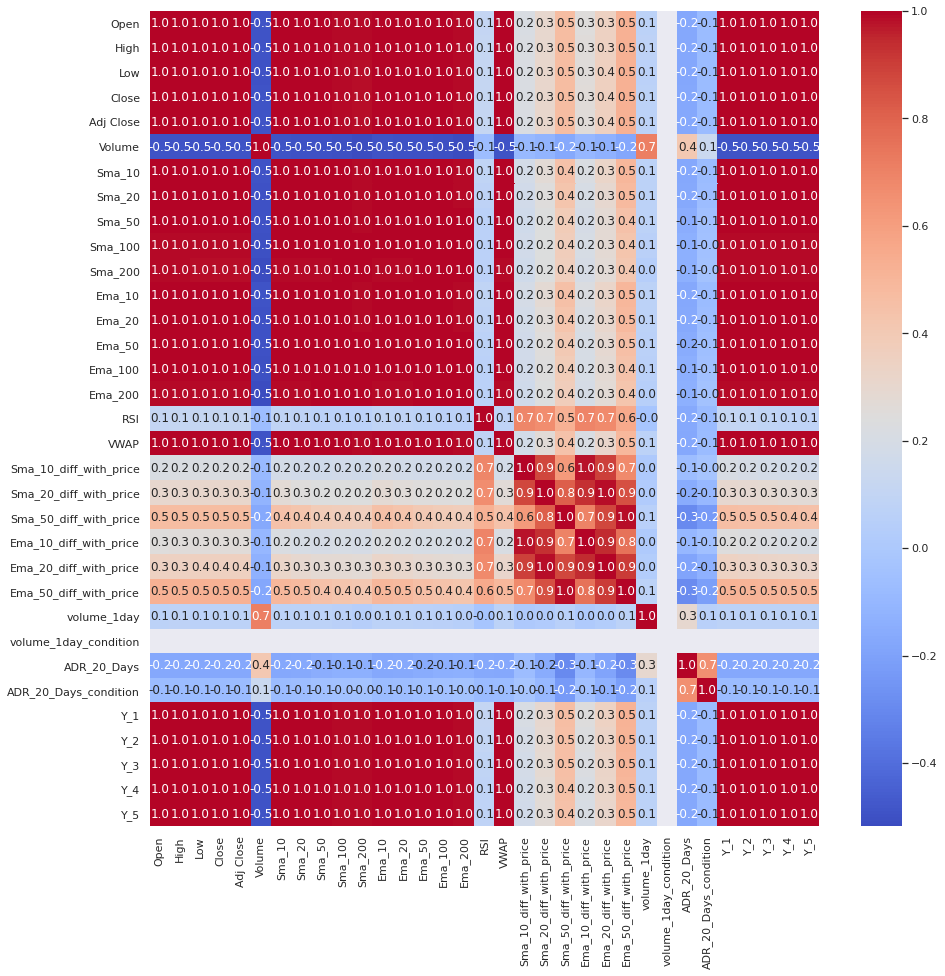

In [53]:
#Assumption 2: Low to No collinearity
plt.figure(figsize=(15,15))
sns.heatmap(data_googl.corr(), cmap='coolwarm', annot=True, fmt=".1f") #might need to try regression model using only features that are not highly correlated with each other

<AxesSubplot:>

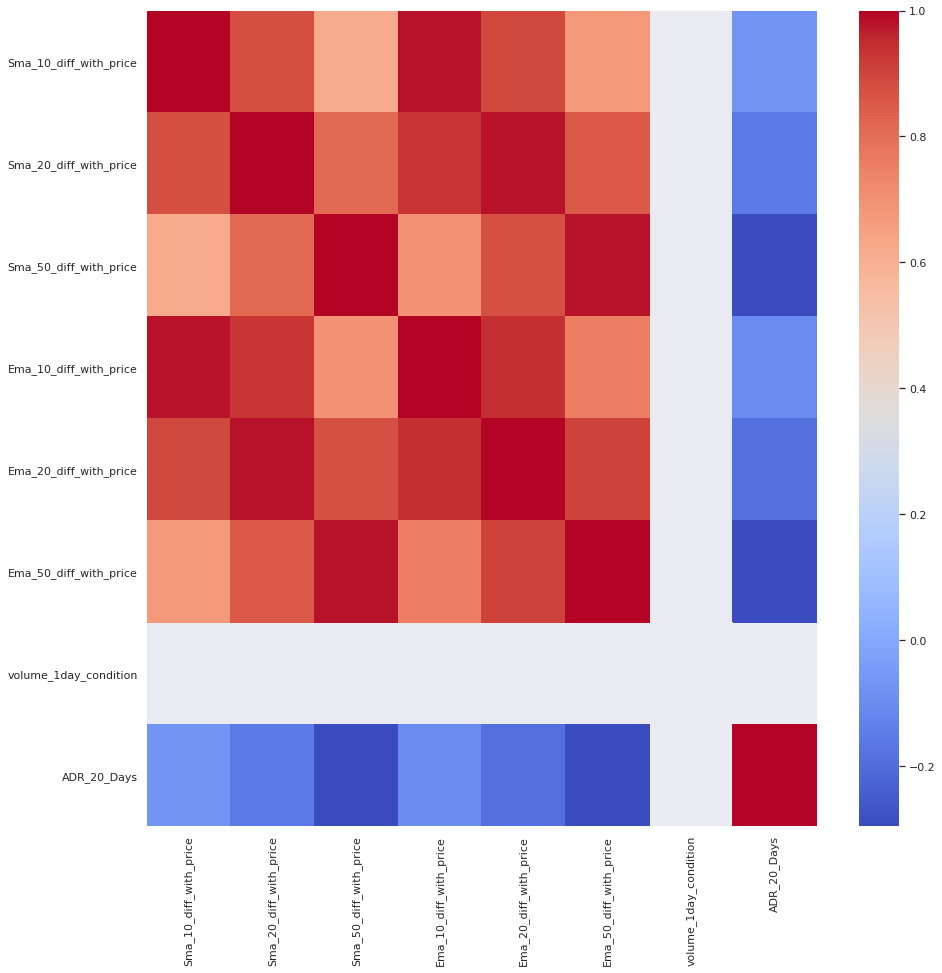

In [57]:
#set of features that have a low correlation: 
temp_df = data_googl[["Sma_10_diff_with_price", "Sma_20_diff_with_price", "Sma_50_diff_with_price", "Ema_10_diff_with_price", "Ema_20_diff_with_price", "Ema_50_diff_with_price", "volume_1day_condition", "ADR_20_Days"]]
plt.figure(figsize=(15,15))
sns.heatmap(temp_df.corr(), cmap='coolwarm')